# PLWE attack

Notebook to analyze generalized root-based attacks over small error values, in terms of the "distribution ratio" r = q/(sqrt(2) * sigma_dist)

# Preliminaries

In [75]:
# work with number fields, primes
import galois, sympy
# parallelized executions
from joblib import Parallel, delayed
# useful math functions for root-based calculations
from math import erf, ceil, sqrt, floor, isnan
# Iterate process
import numpy as np
# Big numbers
import decimal
#Pickle data
import pickle
#Random subset selection
import random
# Graphs
import matplotlib.pyplot as plt
# Handle big numbers
import sys
# Track progress
from tqdm import tqdm
# Interpolate
from scipy.interpolate import interp1d

Auxiliary process to save long computations

In [ ]:
def save_data(data, filename):
    file = open(filename, 'wb')
    # dump information to that file
    pickle.dump(data, file)
    # close the file
    file.close()
    
def load_data(filename):
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')
    # dump information to that file
    data = pickle.load(file)
    # close the file
    file.close()

    return data

In [2]:
#Auxiliar Pow version
def myPow(x: float, n: int) -> float:
    if n == 0:
        return 1.0
    elif x >= sys.float_info.max:
        return float('inf')
    elif n < 0:
        return 1 / myPow(x, -n)
    elif n % 2:
        return myPow(x * x, n // 2) * x
    else:
        return myPow(x * x, n // 2)

In [76]:
#Definitions of each distribution case
def case_distribution_1(n, sigma):
    quot = 1
    factor = myPow(sigma, 2)*n
    return sqrt(factor*quot)

def case_distribution_2(n, sigma, root, ord):
    quot = (myPow(root, 2*ord) - 1)//(myPow(root, 2) - 1)
    factor = (n/ord)*myPow(sigma, 2)
    return sqrt(factor*quot)

def case_distribution_3(n, sigma, root):
    quot = (myPow(root, 2*n) - 1)//(myPow(root, 2) - 1)
    factor = myPow(sigma, 2)
    return sqrt(factor*quot)

def case_distribution_4(n, sigma, root):
    quot = myPow(root, n)//sqrt(myPow(root, 2) - 1)
    factor = sigma
    return factor*quot

In [4]:
def A(r):
    return (erf(r/4))/2

def N(r):
    return (sqrt(2)/r) - (1/2)

def Bterm(k, r):
    return (erf(r*(k + (5/4))) - erf(r*(k + (3/4))))/2

def B(r, j):
    value = 0.0
    for k in range(j):
        value += Bterm(k , r)
    return value

def I(r, j):
    return 2*(A(r) + B(r, j))

simulation = 10

def Icota(r):
    j = simulation*ceil(N(r))
    return 2*(A(r) + B(r, j))

In [93]:
def success_check(ratio, q):
    if q % 4 == 1:
        check = 1/2 + 1/(2*q)
    elif q % 4 == 3:
        check = 1/2 - 1/(2*q)
    else:
        return 0

    return ratio - check

# Interpolation analysis of probability value $P(E_i | D = G_{\sigma})$

The probability value, marked by the 'error' function, is costly to compute, particularlly among very small ratios (given on huge image Gaussian standard deviations). Therefore, it can be an interesting analysis to interpolate this value to get an approximation of the likelihood of the attack's applicability.

In [85]:
precision = 1000
xcoord=[]
ycoord=[]
lower_limit = 0
upper_limit = 1 * 10**(-5)

iterable = np.linspace(lower_limit, upper_limit, precision)

for x in tqdm(iterable, desc="Processing"):
    if x == 0:
      continue
        
    y = Icota(x)
    xcoord.append(x)
    ycoord.append(y)

Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:12:58<00:00,  4.38s/it]


In [86]:
save_data(xcoord, 'interpolation_Inputs')
save_data(ycoord, 'interpolation_Outputs')

In [ ]:
xcoord = load_data('interpolation_Inputs')
ycoord = load_data('interpolation_Outputs')

In [87]:
interpolator = interp1d(xcoord, ycoord, kind='linear', fill_value="extrapolate")

def Icota_interpolated(r):
    return interpolator(r)

Function plot:

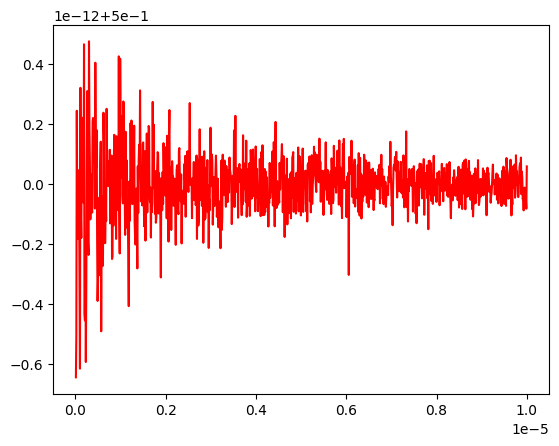

In [88]:
fig, ax = plt.subplots()
l, = ax.plot(xcoord, ycoord, 'r-')

plt.show()

# Cyclotomic root search over finite fields

We define cyclotomic polynomials in order to get either their roots over $\mathbb{F}_q$ or their $k$-ideal factors.

In [6]:
# Returns the cyclotomic polynomial of the form x^N + 1
def cyclotomic_min_pol_power_of_two(N, q):
    return galois.Poly.Degrees([N, 0], coeffs=[1, 1], field=galois.GF(q))

# Returns the cyclotomic polynomial of the form x^(p-1) + ... + x + 1
def cyclotomic_min_pol_prime(N, q):
    degrees = list(range(N))[::-1]
    coeffs = [1 for x in range(N)]
    return galois.Poly.Degrees(degrees, coeffs = coeffs, field=galois.GF(q))

# Process to get roots and k-ideal factors of a certain cyclotomic polynomial
def process_outer_task_min_total_info(N, q, prime):
    # min pol
    if prime == True:
        #prime cyclotomic
        pol = cyclotomic_min_pol_prime(N, q)
    else:
        # power-of-two cyclotomic
        pol = cyclotomic_min_pol_power_of_two(N, q)
    total_info = []
    
    # roots info 
    list_roots_info = [(int(x), x.multiplicative_order()) for x in pol.roots()]

    # k-ideal factors info
    list_factors_info = []
    factors, multiplicities = pol.factors()
    for k in range(2, 5):
        list_terms = []
        for g in factors:
            if g.degree == k:
                non_zero_degrees = [int(x) for x in g.nonzero_degrees]
                if len(non_zero_degrees) == 2 and non_zero_degrees[1] == 0:
                    non_zero_coeffs = [x for x in g.nonzero_coeffs]
                    independent_term = int(-non_zero_coeffs[1])
                    order_independent_term = (-non_zero_coeffs[1]).multiplicative_order()
                    list_terms.append((independent_term, order_independent_term))
        if len(list_terms) > 0:
            list_factors_info.append((k, list_terms))

    total_info.append((N, q, list_roots_info, list_factors_info))
    #return all information
    return total_info

def parallelized_task_min_pol_total_info_cyclotomic(list_N_values, list_q_values, prime=False):
    # get total info
    list_min_pols_total_info = []
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_min_total_info)(N, q, prime)
                                  for N in list_N_values
                                  for q in list_q_values)

    for result in results:
        list_min_pols_total_info.extend(result)
    return list_min_pols_total_info

In [7]:
def get_roots_info(list_total_info):
    list_roots_info = []
    for (N, q, roots, factors) in list_total_info:
        list_roots_info.append((N, q, roots))
    return list_roots_info

def get_factors_info(list_total_info):
    list_factors_info = []
    for (N, q, roots, factors) in list_total_info:
        list_factors_info.append((N, q, factors))
    return list_factors_info

In [22]:
def get_best_elem(list_elem_info, k):
    best_result = float('inf')
    min_value = None
    min_order = None
    for (value, order) in list_elem_info:
        result = myPow(value, order//k)
        if result < best_result:
            best_result = result
            min_value = value
            min_order = order
    return [(min_value, min_order)]

# Small error value attack computations

In [95]:
# Get Small Error Values change of each instance
def likelihood_small_err_values_chances_raw(N, q, sigma, alpha, order, interpolated=False):
    if alpha == None:
        # not a root
        return 0
    if order == 1:
        sigma_image = case_distribution_1(N, sigma)
    elif order < 5:
        sigma_image = case_distribution_2(N, sigma, alpha, order)
    else:
        sigma_image = case_distribution_3(N, sigma, alpha)
        if isnan(sigma_image):
            # try an approximate version that reduces the numeric computations
            sigma_image = case_distribution_4(N, sigma, alpha)
        if isnan(sigma_image):
            return 0
    if (q/4 < 2*sigma_image):
        ratio = q/(sqrt(2) * sigma_image)
        if interpolated:
            return Icota_interpolated(ratio)
        else:
            return Icota(ratio)
    else:
        return 1

# Get Small Error Values change of each instance
def likelihood_small_err_values_chances(N, q, sigma, alpha, order, interpolated=False):

    r = likelihood_small_err_values_chances_raw(N, q, sigma, alpha, order, interpolated)
    return success_check(r, q)

# Main parallelized execution
def parallelized_task_small_err_values_chances(list_total_info, sigma, applyFilter=False, interpolated=False):
    list_chances_sva = []
    (N, q, roots_info) = get_roots_info(list_total_info)[0]
    # check for empty lists
    if len(roots_info) == 0:
        return list_chances_sva
    # filter by smallest image Gaussian
    if applyFilter:
        roots_info = get_best_elem(roots_info, 1)
    results = Parallel(n_jobs=-1)(delayed(likelihood_small_err_values_chances)(N, q, sigma, alpha, order, interpolated)
                                  for (alpha, order) in roots_info)
    for result in results:
        list_chances_sva.append(result)
    return list_chances_sva

def likelihood_small_err_values_chances_k_ideals(N, q, sigma, value, order, k, interpolated=False):
    if value == None:
        # not a real k-ideal factor
        return 0
    n = N//k
    if order == 1:
        sigma_image = case_distribution_1(n, sigma)
    elif order < 5:
        sigma_image = case_distribution_2(n, sigma, value, order)
    else:
        sigma_image = case_distribution_3(n, sigma, value)
        if isnan(sigma_image):
            # try an approximate version that reduces the numeric computations
            sigma_image = case_distribution_4(n, sigma, value)
        if isnan(sigma_image):
            return 0
    if (q/4 < 2*sigma_image):
        ratio = q/(sqrt(2) * sigma_image)
        if interpolated:
            return success_check(Icota_interpolated(ratio), q)
        else:
            return success_check(Icota(ratio), q)
    else:
        return 1

# Main parallelized execution
def parallelized_task_small_err_values_chances_k_ideals(list_total_info, sigma, applyFilter=False, interpolated=False):
    list_chances_sva = []
    (N, q, factors_info) = get_factors_info(list_total_info)[0]
    if len(factors_info) == 0:
        return list_chances_sva
    (k, factor_elems) = factors_info[0]
    # filter by smallest image Gaussian
    if applyFilter:
        roots_info = get_best_elem(factor_elems, k)
    results = Parallel(n_jobs=-1)(delayed(likelihood_small_err_values_chances_k_ideals)(N, q, sigma, value, order, k, interpolated)
                                  for (value, order) in factor_elems)
    for result in results:
        list_chances_sva.append(result)
    return list_chances_sva

def small_err_value_ratio(list_chances_sva):
    if len(list_chances_sva) == 0:
        return 0.0
    return len([p for p in list_chances_sva if p > 0])/len(list_chances_sva)

# Estimation of attack likelihood of practical instances

ML-KEM setting (q = 3329, N = 256)

In [30]:
list_mlkem = parallelized_task_min_pol_total_info_cyclotomic([256], [3329])

In [96]:
small_err_value_ratio(parallelized_task_small_err_values_chances_k_ideals(list_mlkem, 2, True, True))

0.0

ML-DSA (q = 8380417, N = 256)

In [31]:
list_mldsa = parallelized_task_min_pol_total_info_cyclotomic([256], [8380417])

In [34]:
small_err_value_ratio(parallelized_task_small_err_values_chances(list_mldsa, 2))

0.0

# Example: Case Distribution 2)

Example instance thought not to be applicable, but is due to refined bound

In [110]:
sigma = 8
degree = 256
q = 3331
alpha = q-1
order = 2

r = likelihood_small_err_values_chances_raw(degree, q, sigma, alpha, order)
r, success_check(r, q)

(0.49999999999999806, 0.00015010507354956681)

Example instance thought to be applicable, but is not due to refined bound

In [112]:
sigma = 8
degree = 256
q = 4013
alpha = q-1
order = 2

r = likelihood_small_err_values_chances_raw(degree, q, sigma, alpha, order)
r, success_check(r, q)

(0.5000000000000001, -0.00012459506603523796)

# Example: Case Distribution 3)

Example instance thought not to be applicable, but is due to refined bound

In [42]:
sigma = 8
degree = 256
q = 2887
alpha = 698
order = 3

r = likelihood_small_err_values_chances_raw(degree, q, sigma, alpha, order)
r, success_check(r, q)

(0.499999999999982, 0.0001731901627807786)

Example instance thought to be applicable, but is not due to refined bound

In [72]:
sigma = 8
degree = 256
q = 4057
alpha = 1408
order = 3

r = likelihood_small_err_values_chances_raw(degree, q, sigma, alpha, order)
r, success_check(r, q)

(0.5000000000000161, -0.0001232437761732319)